# Adiabatic switching in Quantum Monte Carlo
The programme computes the free energy for the double well potential $V(x)=\lambda\left(x^2-\eta^2\right)^2$ adopting the adiabatic switching method. The results are compared with the free energy computation from exact diagonalization, and hysteresis effects are studied as well to obtain a better estimate of errors.

Input parameters, with default values:
- potential parameters: $\lambda=1$, $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points to start with: $N=20$
- lattice spacing: $a=0.05$
- number of Metropolis configurations: $N_{sweeps}=100$
- number of sweeps between each measurement: $N_{cor}=50$
- number of iterations $n$ in $N$, with $N(n)=N\cdot 2^n$, starting from $n=0$: $n=6$
- oscillator constant of the reference system: $\omega_0=4\eta=5.6$
- number of steps in adiabatic switching: $N_{switch}=20$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy import diff
import math
import random
from tqdm.notebook import tqdm

In [2]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1)
eta = float(input("eta = ") or 1.4)
m = float(input("m = ") or 1/2)
hbar = 1;

lambda = 
eta = 
m = 


In [3]:
# Lattice parameters
N = int(input("N = ") or 20)
a = float(input("a = ") or 0.05)
Nsweeps = int(input("Nsweeps = ") or 100)
Ncor = int(input("Ncorrelation = ") or 50)

N = 
a = 
Nsweeps = 1000
Ncorrelation = 100


In [4]:
# Additional parameters
n = int(input("n = ") or 6)                  # Number of iterations in N
w0 = float(input("omega0 = ") or 4*eta)      # Reference system oscillator constant
Nswitch = int(input("Nswitch = ") or 20)     # Number of steps in adiabatic switching

n = 
omega0 = 
Nswitch = 


In [5]:
eps = float(input("epsilon = ") or 0.5)

# Function that updates x according to Metropolis algorithm
def update(x, alpha, N):
    
    for j in range(N):
        old_x = x[j]                                    # Save the original values
        old_Sj, deltaS = S(j, x, alpha, N)
        x[j] = x[j] + random.gauss(0, eps)              # Update x[j]
        new_Sj, deltaS = S(j, x, alpha, N)
        dS = new_Sj - old_Sj                            # Change in action
        
        if np.exp(-dS) < random.random():               # Metropolis acceptance criterium
            x[j] = old_x                                # Restore the old value in case the condition is not satisfied

epsilon = 


## Adiabatic switching
An effective method to compute the free energy of the system $S$ is to start from a reference system whose free energy is known, and whose action we denote by $S_0$, and then consider the action:

$$
S_\alpha = S_0 + \alpha\Delta S\qquad\qquad \Delta S = S-S_0
$$

which interpolates between the actual system and the reference one, being $\alpha\in [0,1]$. By integrating the equation that defines $Z$,

$$
Z(\alpha) = \int \mathcal{D}x\ e^{-S_\alpha}\qquad\longrightarrow\qquad \frac{\partial\log{Z}}{\partial\alpha} = -\frac{\int\mathcal{D}x\ S_\alpha e^{-S_\alpha}}{\int\mathcal{D}x\ e^{-S_\alpha}} = -\left<\Delta S\right>_\alpha
$$
we find:
$$
\frac{\partial}{\partial\alpha}\log{Z(\alpha)}=-\left<\Delta S\right>_\alpha\qquad\longrightarrow\qquad
\log{\left[Z(\alpha=1)\right]}=\log{\left[Z(\alpha=0)\right]}-\int_0^1 d\alpha' \left<\Delta S\right>_{\alpha'}
$$

where the expectation value is computed with respect to the action $S_\alpha$. In our case, the simplest reference system we can choose is the harmonic oscillator, for which we know that:

$$
V(x)=\frac{1}{2}m\omega_0^2x^2\qquad\mbox{and} \qquad E_n=\omega_0\left(n+\frac{1}{2}\right) \qquad\longrightarrow\qquad
Z(\alpha=0) = \sum_n e^{-\beta E_n} = \frac{e^{-\frac{1}{2}\beta\omega_0}}{1-e^{-\beta\omega_0}}
$$

The evaluation of the action can be again limited to $j$-dependent terms, but now we need as an output the variation $\Delta S_j$ as well. To get the overall variation, it is then possible to sum all $j$-terms as $\Delta S=\sum_j \Delta S_j$.

In [6]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def S(j, x, alpha, N):
    
    if j == N-1:
        Kin = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a)       # Periodic boundary conditions
    else:
        Kin = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a)
            
    V0 = 1/2*m*w0**2*x[j]**2                                  # Reference system potential (harmonic oscillator)
    V1 = (x[j]**2 - eta**2)**2                                # Double well potential
    
    V = alpha*(V1-V0) + V0                                    # Interpolation between the two
    Action = Kin + a*V
    deltaS = a*(V1-V0)                                        # Difference in action in the two cases
                                                              # (only for j-dependent terms)
    return Action, deltaS

### Free energy computation
The following loop over the coupling constant $\alpha$ allows to compute the value of the free energy $F=-T\log{Z}$ for different temperatures $T$. Since $T=\beta^{-1}$, where $\beta$ is the total euclidean time, and $\beta=Na$, we can vary $T$ in two different ways:
- by changing the number of steps $N$ for each iteration;
- by changing the lattice spacing $a$.

Here we adopt the first method, which allows to keep always the same grid resolution and requires to change only the total euclidean time. The statistical error on $\left<\Delta S_\alpha\right>$ is estimated with the usual formula of Monte Carlo simulations:

$$
\Delta\left<\mathcal{O}\right>=\sqrt{\frac{\left<\mathcal{O}^2\right>-\left<\mathcal{O}\right>^2}{N_{sweeps}}}
$$

The error on the integral is taken to be an average of the error of the integrand function.

In [7]:
# Initialize the vectors needed
deltaS_tot = np.zeros([2*Nswitch+1, n])          # Total difference in action
deltaS2_tot = np.zeros([2*Nswitch+1, n])         # Total difference in action squared
mean_deltaS = np.zeros([2*Nswitch+1, n])         # Mean value of the difference in action
mean_deltaS2 = np.zeros([2*Nswitch+1, n])        # Mean value of the difference in action squared (for error estimate)
alpha_vec = np.zeros(2*Nswitch+1)                # Values of alpha explored

integral_dS1 = np.zeros(n)                       # Integrals of the mean value, forward and backward
integral_dS2 = np.zeros(n)

logZ_vec = np.zeros(n)                           # Logarithm of the partition function
T_vec = np.zeros(n)                              # Temperature
F_vec = np.zeros(n)                              # Free energy

N0 = int(N)                                      # Variable N

for iT in tqdm(range(n), leave = False):
    dalpha = 1/Nswitch                           # Lattice separation in alpha space
    beta = N0*a                                  # Total euclidean time
    T_vec[iT] = 1/beta                           # Corresponding temperature
    
    x = np.zeros(N0)                             # Cold start
    
    for ialpha in tqdm(range(2*Nswitch+1), leave = False):      # Loop on twice the number of steps
        
        if ialpha < Nswitch:                                    # Building the coupling constant vector
            alpha = ialpha*dalpha                               # (from 0 to 1 and then from 1 to 0)
            alpha_vec[ialpha] = alpha
        else:
            alpha = 2-ialpha*dalpha
            alpha_vec[ialpha] = alpha 

        for j in range(5*Ncor):                                # Initial thermalization
            update(x, alpha, N0)
        for k in tqdm(range(Nsweeps), leave = False):
            for j in range(Ncor):                              # Thermalization steps between each measurement
                update(x, alpha, N0)

            deltaS = 0                                         # Compute the difference in action
            for j in range(N0):                                # Sum over all lattice points
                _, deltaSj = S(j, x, alpha, N0)
                deltaS = deltaS + deltaSj
            
            # Sum over all configurations
            deltaS_tot[ialpha, iT] = deltaS_tot[ialpha, iT] + deltaS
            deltaS2_tot[ialpha, iT] = deltaS2_tot[ialpha, iT] + deltaS**2
    
    mean_deltaS[:, iT] = deltaS_tot[:, iT] / Nsweeps           # Compute the mean value over configurations
    mean_deltaS2[:, iT] = deltaS2_tot[:, iT] / Nsweeps
    

    # Integration with trapeziodal rule of the mean values w.r.t. alpha
    # (1 is in going forward, 2 in going backward, so it has to be summed with opposite sign)
    integral_dS1[iT] = np.trapz(mean_deltaS[0:Nswitch+1, iT], alpha_vec[0:Nswitch+1])
    integral_dS2[iT] = - np.trapz(mean_deltaS[Nswitch:2*Nswitch+1, iT], alpha_vec[Nswitch:2*Nswitch+1])

    Z0 = np.exp(-beta*w0/2) / (1-np.exp(-beta*w0))                             # Partition function of the reference system 
    
    logZ_vec[iT] = np.log(Z0) - (integral_dS1[iT] + integral_dS2[iT])/2        # Adiabatic switching formula
    F_vec[iT] = logZ_vec[iT]*T_vec[iT]                                         # Free energy
    
    N0 = int(N0*2)          # Update the value of N0 at the end of each iteration
    

# Statistical error estimate
stat_err = np.sqrt(np.abs(mean_deltaS2 - mean_deltaS**2) / Nsweeps)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### Hysteresis effects
In order to take into account possible hysteresis effects, the above integral has been computed two times, by letting $\alpha$ grow from $0$ to $1$ (which is the _forward_ one) and then by letting it decrease from $1$ to $0$, coming back to the starting point (_backward_ integral). The hysteresis error is then estimated as:

$$
\delta F_{Hyst}=\frac{T}{2} \left|\int_0^1 d\alpha' \left<\Delta S\right>_{\alpha'} - \int_1^0 d\alpha' \left<\Delta S\right>_{\alpha'}\right|
$$

The following plots show the hysteresis effects, which turn out to be non-negligible with the default choice of parameters. In particular, one finds that $\delta F_{Hyst} \approx 0.1\div 0.2\,\%$ for $N_{switch}=20$; increasing $N_{switch}$ would reduce this systematic error, but the time required increases a lot as well.

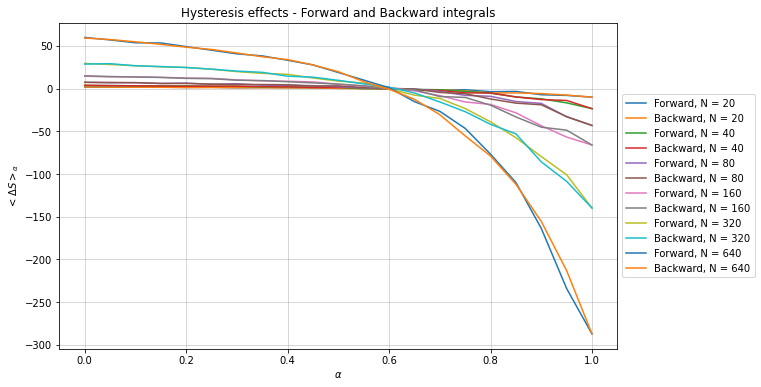

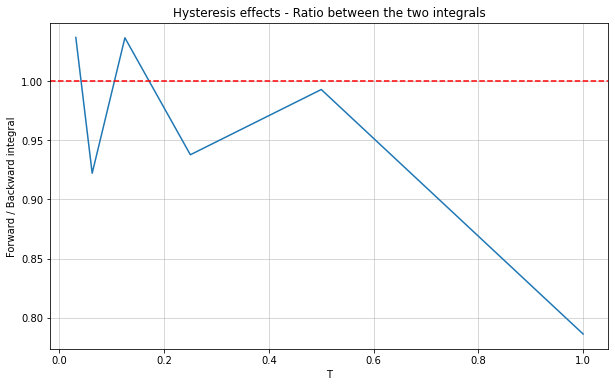

In [8]:
# Mean values plot as a function of alpha
fig, ax = plt.subplots(figsize=(10,6))

N0 = N
for iT in range(n):
    ax.plot(alpha_vec[0:Nswitch+1], mean_deltaS[0:Nswitch+1, iT], label = 'Forward, N = '+str(round(N0)))
    ax.plot(alpha_vec[Nswitch:2*Nswitch+1], mean_deltaS[Nswitch:2*Nswitch+1, iT], label = 'Backward, N = '+str(round(N0)))
    N0 = 2*N0
    
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$<\Delta S>_\\alpha$')
plt.grid(linewidth = 0.5)
plt.title('Hysteresis effects - Forward and Backward integrals')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));
plt.show()

# Ratio between integrals
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(T_vec, np.abs(integral_dS1 / integral_dS2))
plt.axhline(y = 1, ls = '--', color = 'red')
ax.set_xlabel('T')
ax.set_ylabel('Forward / Backward integral')
plt.grid(linewidth = 0.5)
plt.title('Hysteresis effects - Ratio between the two integrals')
plt.show()

# Hysteresis error estimate (the factor T is included at the end of the code)
hyst_err = np.abs(integral_dS1 - integral_dS2) / 2

### Total error
The total error associated to the Monte Carlo points is computed by assuming that the different sources of errors are independent, so summing the square of statistical and hysteresis errors, and then taking the square root of the result:

$$
\delta F = \sqrt{\left(\delta F_{Hyst}\right)^2 + \left(\delta F_{Stat}\right)^2}
$$

In [9]:
# Total error evaluation
err = np.zeros(n);

for iT in range(n):
    err[iT] = np.sqrt( np.square(np.mean(stat_err[:, iT])) + hyst_err[iT]**2 )

## Exact diagonalization
We repeat the exact diagonalization procedure in order to compare it with the Monte Carlo data.

In [11]:
Ngrid = 800;
xmin = -5;
xmax = 5;

# Potential
xvec = np.linspace(xmin, xmax, Ngrid);     # Vector spanning from xmin to xmax with Ngrid points
Vx = Lambda*(xvec**2-eta**2)**2;

# Kinetic energy discretization
dx = np.diff(xvec).mean();     # Grid resolution
diag = -2*np.ones(Ngrid);      # -2f(x)
offdiag = np.ones(Ngrid-1);    # f(x+dx) and f(x-dx)

d2grid = np.mat(np.diag(diag,0) + np.diag(offdiag,-1) + np.diag(offdiag,1))/dx**2;     # Discretized second derivative

# Avoid problems at the edge of the grid
d2grid[0,:] = 0;
d2grid[Ngrid-1,:] = 0;

Ekin = -hbar**2/(2*m)*d2grid;

# Potential energy discretization
Epot = np.mat(np.diag(Vx, 0))

# Total Hamiltonian diagonalization
H = Ekin + Epot;
w, v = LA.eig(H);

sortinds = np.argsort(w);     # Returns the indices that would sort the array w
EigVals = w[sortinds];        # Eigenvalues sorting
EigVecs = v[:,sortinds];      # Corresponding eigenvectors sorting

### Free energy from exact diagonalization
The free energy can be also computed from exact diagonalization, by using the definition of partition function with a discrete set of energy levels $E_n$, the exactly computed eigenvalues:

$$
Z(T) = \sum_n e^{-\beta E_n}
$$

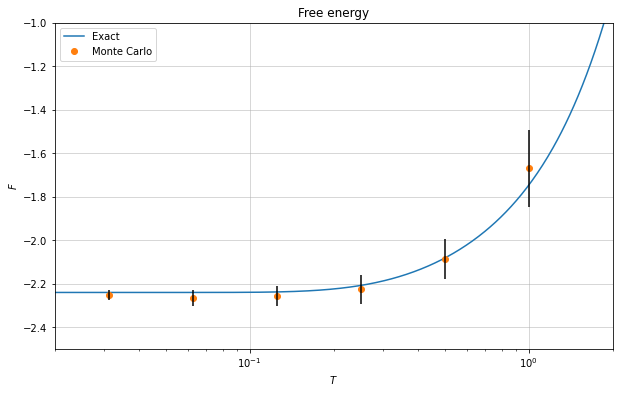

In [24]:
# Bounds
xmin = 0.1
xmax = 100
xlogmax = np.log(xmax)
xlogmin = np.log(xmin)
xlog_vec = np.linspace(xlogmin, xlogmax, Ngrid)

F = np.zeros(Ngrid)              # Initialize the free energy
T = np.zeros(Ngrid)              # Initialize the temperature

for il in range(Ngrid):
    xlog = xlog_vec[il]
    xl = np.exp(xlog)
    T[il] = 1/xl
    Z  = 0;                      # Initialize the partition function
    
    for i in range(Ngrid):                  # Compute the partition function
        Z = Z + np.exp(-EigVals[i]*xl)
    
    F[il] = T[il]*np.log(Z)                 # Compute the free energy
    

# Plotting the results
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(T, F, label = 'Exact')
plt.xlim([0.02, 2])
plt.ylim([-2.5, -1])
ax.set_xlabel('$T$')
ax.set_ylabel('$F$')
ax.set_xscale('log')
plt.grid(linewidth = 0.5)
plt.title('Free energy')

# Adding Monte Carlo data to the plot
ax.plot(T_vec, F_vec, 'o', label = 'Monte Carlo');
plt.errorbar(T_vec, F_vec, yerr = err*T_vec, xerr = None, fmt = 'None', ecolor = 'black');
plt.legend()
plt.show()

## Virial theorem
The adiabatic switching method allows to compute the free energy of the anharmonic oscillator with acceptable precision, even though the computation requires much more time than the direct diagonalization and cannot be extended to very low values of $T$, since they would require large $N$ or tiny $a$, which are both time consuming configurations. In that case, it is much more efficient to compute the ground state energy by directly measuring the expectation value of the Hamiltonian, $E_0=\left<H\right>$. To avoid divergences of the time derivative in the kinetic term, which occour in the continuum limit, we can use the Virial theorem:

$$
\left<H\right> = \left<T+V\right> = \left<\frac{x}{2}V'+V\right>
$$

In [7]:
def Virial(x, N):
    H = 0
    V = np.power((x**2 - eta**2), 2)
    derV = 4*x*(x**2 - eta**2)
    
    H = sum(0.5*x*derV + V) / N
    
    return H

def VirialMC(N):
    x = np.zeros(N)
    H = 0
    H2 = 0

    for j in range(5*Ncor):
        update(x, 0, N)
        
    for i in tqdm(range(Nsweeps), leave = False):
        for j in range(Ncor):
            update(x, 0, N)
        V = Virial(x, N)
        H = H + V
        H2 = H2 + V**2
    
    H = H / Nsweeps
    H2 = H2 / Nsweeps
    err = np.sqrt((H2 - H**2) / Nsweeps)
    
    return H, err

In [14]:
Nsweeps = int(input("Nsweeps = ") or 100)
Ncor = int(input("Ncorrelation = ") or 50)
Npoints = int(input("Npoints = ") or 6)

N = 20

H_vec = np.zeros(Npoints)
T_vec = np.zeros(Npoints)
err_vec = np.zeros(Npoints)

for j in tqdm(range(Npoints), leave = False):
    H_vec[j], err_vec[j] = VirialMC(N)
    T_vec[j] = 1 / (N*a)
    N = 2*N

Nsweeps = 1000
Ncorrelation = 100
Npoints = 


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

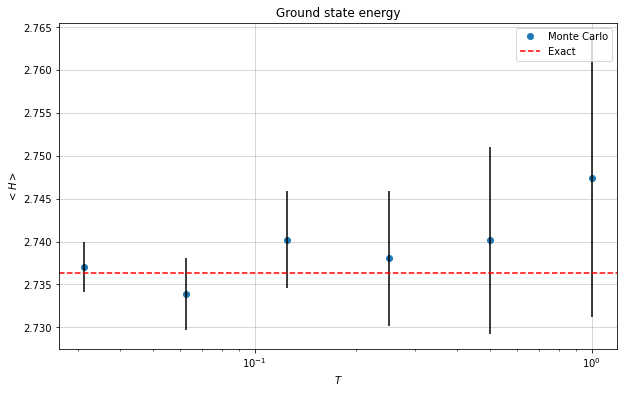

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(T_vec, H_vec, 'o', label = 'Monte Carlo')
plt.errorbar(T_vec, H_vec, yerr = err_vec, xerr = None, fmt = 'None', ecolor = 'black');
plt.axhline(y = EigVals[1], ls = '--', color = 'red', label = 'Exact')
ax.set_xlabel('$T$')
ax.set_ylabel('$<H>$')
ax.set_xscale('log')
plt.grid(linewidth = 0.5)
plt.title('Ground state energy');
plt.legend();